In [1]:
## load packages
import os 
import pathlib
import pickle as pkl
import gdown

import sklearn
import seaborn as sns
import pyarrow
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import re

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
pd.set_option('display.max_columns', None)

#### BILLS
RULES: 
- Include states with only lobbying records (IA, MA, NE, NJ, RI, WI)
- Include only bills from years where position data is available (IA: 2009-2022, MA: 2010-2021, NE: 2000-2021, NJ: 2014-2022, RI: 2018-2022, WI: 2002-2022)
- Include bills with status avaiable and remove duplicate bills
- Subset and use columns: state, state_unified_bill_id, bill_year, pass, ncsl_topics, ncsl_metatopics

In [2]:
states_lobby = ["IA", "MA", "NE", "NJ", "RI", "WI"] #states that only have lobby records
#position data for the above states are avaible during the following ranges: 
pos_spans = [range(2009, 2023), range(2009, 2023), range(2000, 2023), range(2014, 2023), range(2018, 2023), range(2002, 2023)]

In [20]:
#BILLS
bills = pd.read_parquet("../data/raw/chorus/bills.parquet") #load bills data
bills_lob = bills[bills["state"].isin(states_lobby)]        #subset states with lobby records
bills_lob = bills_lob[bills_lob["status"].notna()]          #remove rows with no status metadata
print(f"number of duplicated bills: {len(bills_lob[bills_lob["state_unified_bill_id"].duplicated()])}")
bills_lob.drop_duplicates(subset="state_unified_bill_id",   #remove rows with duplicate bill ids
                          ignore_index=True, inplace=True)
bills_lob["pass"] = bills_lob.index.map(bills_lob["status"].isin([4,5]).to_dict())#create new col with binary pass/fail status
bills_lob = bills_lob.replace(to_replace={"ncsl_metatopics":{None: list(["M"])},  #replace none with 'M' (so it can be made to list)
                                          "ncsl_topics":{None: list(["M"])}})
bills_lob["ncsl_topics"] = bills_lob["ncsl_topics"].str.split("; ")               #split topics into lists 
bills_lob["ncsl_metatopics"] = bills_lob["ncsl_metatopics"].str.split("; ")       #split topics into lists 
print(f"number of bills after removing duplicates: {len(bills_lob)}")
#get year from last_action_date
bills_lob["year"] = bills_lob["last_action_date"].str.split(r"-", expand=True)[0]
#subset bills
bills_lob = bills_lob[["state_unified_bill_id", "pass",  "state", "ncsl_topics", "ncsl_metatopics", "year", "bill_chamber"]]

number of duplicated bills: 1358
number of bills after removing duplicates: 195230


In [21]:
#fix year col: inspect years: none, 0000, 1969
print(f"number of bills where year is None, 0000 or 1969: {len(bills_lob[bills_lob["year"].isin([None, "0000", "1969"])])}")
#set year to year-suffix from bill id in the 374 cases above
bills_lob.loc[bills_lob[bills_lob["year"].isin([None, "0000", "1969"])].index, "year"] = bills_lob[bills_lob["year"].isin([None, "0000", "1969"])]["state_unified_bill_id"].str.split("_", expand=True)[3]
#set as type int 
bills_lob["year"] = bills_lob["year"].astype("int32")

number of bills where year is None, 0000 or 1969: 374


In [22]:
#subset so bills only come fra year ranges where there are poistions from each state
keep_ind = []
for i, (state, span) in enumerate(zip(states_lobby, pos_spans)):
    i_ind = bills_lob[(bills_lob["state"] == state) & (bills_lob["year"].isin(span))].index.tolist()
    keep_ind = keep_ind + i_ind

bills_lob = bills_lob.iloc[keep_ind]
print(f"number of bills after removing ones outside position ranges: {len(bills_lob)}")
print(f"\nPercentage of bills passed and failed:\n{bills_lob["pass"].value_counts(normalize = True)}")
#delete to free up space 
del keep_ind, i, i_ind, state, span
bills_lob.head(3)

number of bills after removing ones outside position ranges: 160753

Percentage of bills passed and failed:
pass
False    0.878976
True     0.121024
Name: proportion, dtype: float64


,state_unified_bill_id,pass,state,ncsl_topics,ncsl_metatopics,year,bill_chamber
0,IA_H_0000000001_2013,False,IA,[M],[M],2013,HF
1,IA_H_0000000002_2013,False,IA,[M],[M],2013,HF
2,IA_H_0000000011_2013,False,IA,[M],[M],2013,HF


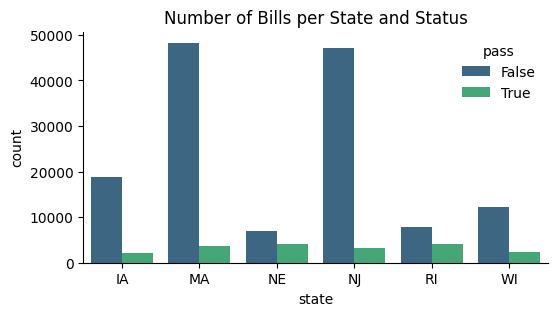

In [23]:
#plot outcomes(passed/failed) by state
fig, ax = plt.subplots(figsize=(6, 3))
p = sns.countplot(bills_lob, x = "state", hue = "pass",stat = "count", palette= "viridis")
sns.move_legend(p, "upper right", frameon = False)
ax.set_title('Number of Bills per State and Status')
sns.despine()
plt.savefig("../figs/bills_status.png")

In [13]:
##pallette so states keep the same colours through the eda
states_palette = dict(zip(states_lobby, sns.color_palette("viridis", 6).as_hex()))

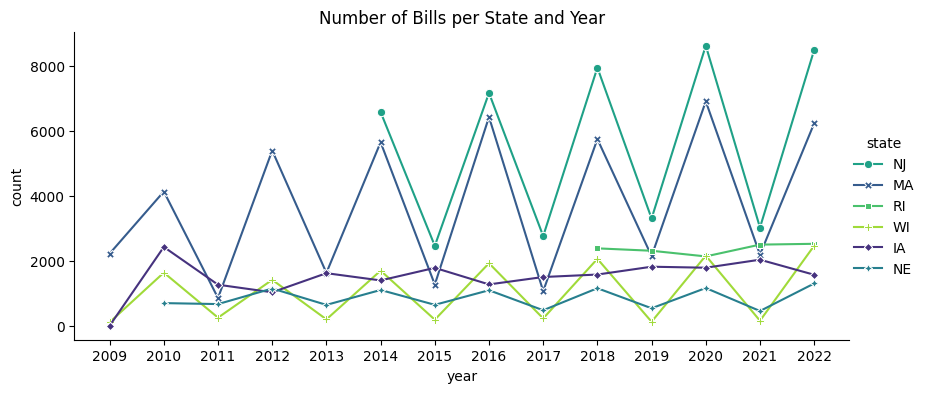

In [24]:
#bills per state per year
fig, ax = plt.subplots(figsize=(10, 4))
p = sns.lineplot(data = bills_lob.value_counts(["state", "year"]).to_frame().reset_index(), 
                 x = "year", y = "count", hue = "state", palette= states_palette, 
                 style="state", markers=True, dashes=False)
sns.move_legend(p, "upper right", bbox_to_anchor=(1.1, 0.7),  frameon = False)
sns.despine()
ax.set_title('Number of Bills per State and Year')
plt.xticks([2009., 2010., 2011., 2012., 2013., 2014., 2015., 2016., 2017., 2018., 2019., 2020., 2021., 2022., ],
           ['2009', '2010', '2011', '2012', '2013', '2014', '2015','2016','2017','2018','2019','2020','2021','2022'])
plt.savefig("../figs/bills_lineplot.png")

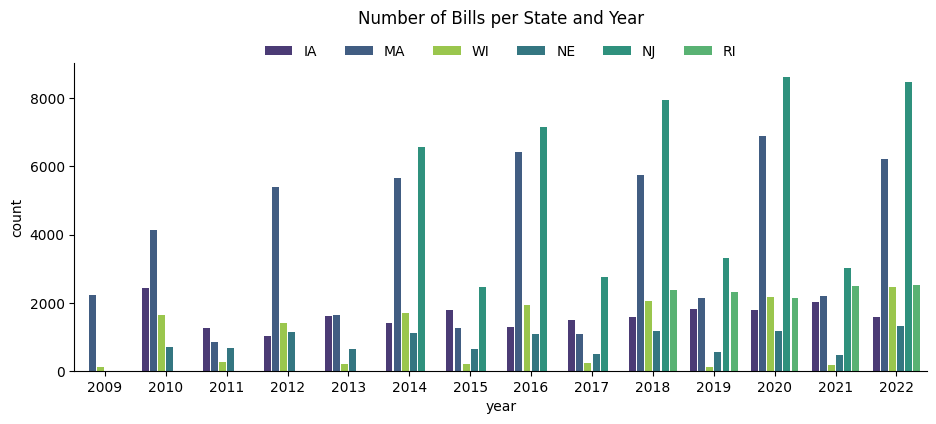

In [27]:
#bills per state per year
fig, ax = plt.subplots(figsize=(11, 4))
p = sns.countplot(bills_lob, x = "year", hue = "state",stat = "count", palette= states_palette, 
                  gap=.15)
sns.move_legend(p, "upper center", bbox_to_anchor=(0.5, 1.1), ncol=6,  frameon=False, title=None)
ax.set_title('Number of Bills per State and Year', y = 1.1)
sns.despine()
plt.savefig("../figs/bills_barplot.png")

number of unique topics: 968
number of unique metatopics: 18


/tmp/ipykernel_16039/591666417.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(np.append(bills_lob["ncsl_metatopics"].explode().unique()[::-1][0:-1], "No NCSL metatopic assigned"))


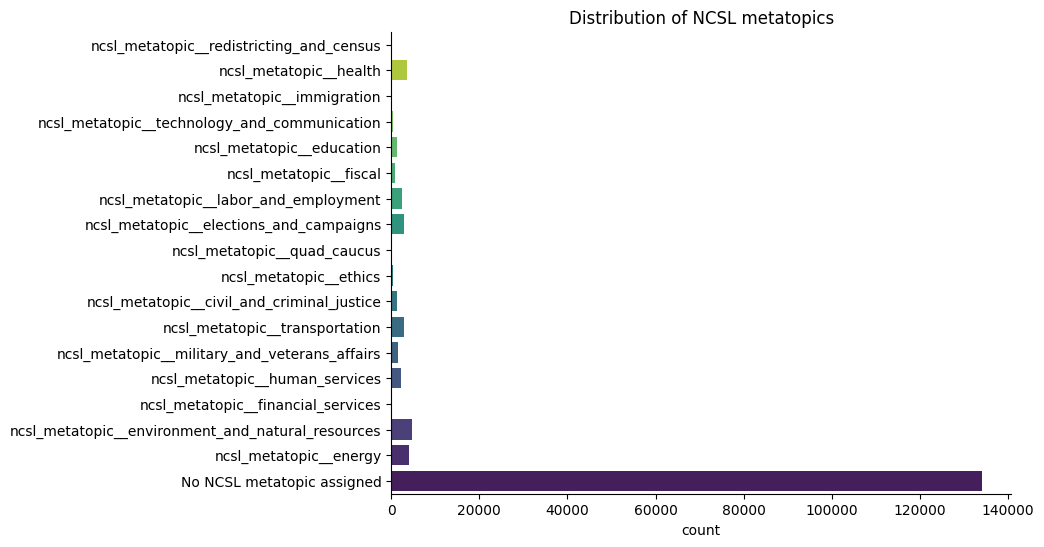

In [28]:
print(f"number of unique topics: {len(bills_lob["ncsl_topics"].explode().unique())}")
print(f"number of unique metatopics: {len(bills_lob["ncsl_metatopics"].explode().unique())}")

fig, ax = plt.subplots(figsize=(8, 6))
sns.countplot(y=bills_lob["ncsl_metatopics"].explode(), order = bills_lob["ncsl_metatopics"].explode().unique()[::-1] ,
              hue=bills_lob["ncsl_metatopics"].explode(), palette="viridis")
sns.despine()
ax.set_title('Distribution of NCSL metatopics')
ax.set_yticklabels(np.append(bills_lob["ncsl_metatopics"].explode().unique()[::-1][0:-1], "No NCSL metatopic assigned"))
plt.ylabel("")
plt.savefig("../figs/metatopic_counts.png")
del ax, fig, p

#### POSITIONS

RULES: 
- Include states with only lobbying records (IA, MA, NE, NJ, RI, WI)
- Include from years where bills also have been collected (IA: 2009-2022, MA: 2010-2021, NE: 2010-2021, NJ: 2014-2022, RI: 2018-2022, WI: 2009-2022)
- All bills in POSITIONS should also be in BILLS (the ones that arent represented in bills were prevously removed due to having status = NA)
- Subset relevant columns (state_client_id, state_unified_bill_id, year, position_numeric)

In [29]:
#POSITIONS
bills_spans = [range(2009, 2024), range(2009, 2023), range(2010, 2023), range(2014, 2024), range(2018, 2024), range(2009, 2024)]

positions = pd.read_parquet("../data/raw/chorus/positions.parquet")#load positions
#subset so positions only come from year ranges where there are bills from each state
keep_ind = []
for i, (state, span) in enumerate(zip(states_lobby, bills_spans)):
    i_ind = positions[(positions["state"] == state) & (positions["year"].isin(span))].index.tolist()
    keep_ind = keep_ind + i_ind
positions_lob = positions.iloc[keep_ind]
positions_lob.head(3)
#del positions to free up space
del positions, keep_ind, i, state, span, i_ind

In [30]:
#check that bills in positions is also in bills df
print(f"number of unique bill ids in positions data: {len(positions_lob["state_unified_bill_id"].unique())}")
print(f"number of unique bill ids in bills data: {len(bills_lob["state_unified_bill_id"].unique())}")
print(f"\nOf bills in positions data also represented in bills data:")
print(positions_lob["state_unified_bill_id"].drop_duplicates().isin(bills_lob["state_unified_bill_id"]).value_counts())

### bills present in positions data but not in bills, was taken out of bills bc status value wasnt avaiable
not_in_bills = positions_lob[~positions_lob["state_unified_bill_id"].isin(bills_lob["state_unified_bill_id"])]["state_unified_bill_id"].unique()
print(bills[bills["state_unified_bill_id"].isin(not_in_bills)]["status"].isna().value_counts())
print("The bills not present in the bills dataset (3603) have status value NA (why they arent there)")
#remove the bills from positions not present in bills data
positions_lob = positions_lob[positions_lob["state_unified_bill_id"].isin(bills_lob["state_unified_bill_id"])]
del bills, not_in_bills

number of unique bill ids in positions data: 89350
number of unique bill ids in bills data: 160753

Of bills in positions data also represented in bills data:
state_unified_bill_id
True     85747
False     3603
Name: count, dtype: int64
status
True    3603
Name: count, dtype: int64
The bills not present in the bills dataset (3603) have status value NA (why they arent there)


In [31]:
#subset relevant columns 
positions_lob = positions_lob[["state_client_id", "state", "state_unified_bill_id", "position_numeric", "year"]] #keep relevant columns
positions_lob = positions_lob.replace(to_replace={"position_numeric": {-1.0: "oppose", 0.0: "neutral", 1.0: "support"}})
positions_lob.reset_index(drop=True, inplace=True)
positions_lob.head(3)

,state_client_id,state,state_unified_bill_id,position_numeric,year
0,IA_0,IA,IA_H_0000002512_2009,support,2010
1,IA_0,IA,IA_H_0000002512_2009,support,2010
2,IA_0,IA,IA_H_0000002512_2009,support,2010


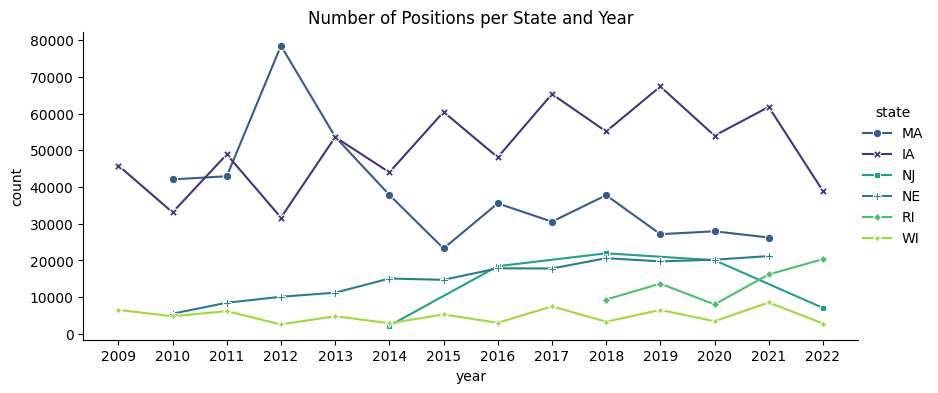

In [32]:
#bills per state per year
fig, ax = plt.subplots(figsize=(10, 4))
p = sns.lineplot(data = positions_lob.value_counts(["state", "year"]).to_frame().reset_index(), 
                 x = "year", y = "count", hue = "state", palette= states_palette, style="state",
                markers=True, dashes=False)
sns.move_legend(p, "upper right", bbox_to_anchor=(1.1, 0.8),  frameon = False)
sns.despine()
ax.set_title('Number of Positions per State and Year')
plt.xticks([2009., 2010., 2011., 2012., 2013., 2014., 2015., 2016., 2017., 2018., 2019., 2020., 2021., 2022., ],
           ['2009', '2010', '2011', '2012', '2013', '2014', '2015','2016','2017','2018','2019','2020','2021','2022'])
plt.savefig("../figs/positions_lineplot.png")

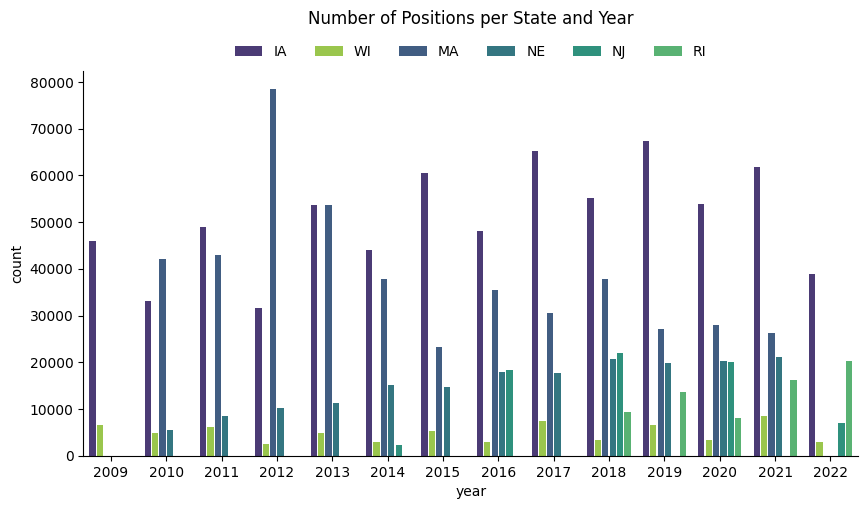

In [33]:
#positions per state per year
fig, ax = plt.subplots(figsize=(10, 5))
p = sns.countplot(positions_lob, x = "year", hue = "state",stat = "count", palette= states_palette, 
                  gap=.15)
sns.move_legend(p, "upper center", bbox_to_anchor=(0.5, 1.1), ncol=6,  frameon=False, title=None)
ax.set_title('Number of Positions per State and Year', y = 1.1)
sns.despine()
plt.savefig("../figs/positions_barplot.png")

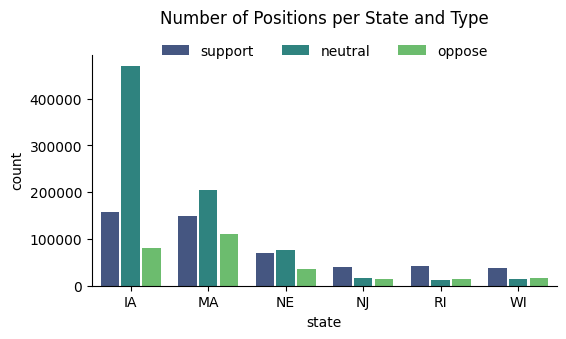

In [34]:
fig, ax = plt.subplots(figsize=(6, 3))
p = sns.countplot(positions_lob, x = "state", hue = "position_numeric",stat = "count", 
                  palette= "viridis",  gap = .1)
sns.move_legend(p, "upper center",  bbox_to_anchor=(0.5, 1.1), ncol=3,  frameon = False, title=None)
ax.set_title('Number of Positions per State and Type', y=1.1)
sns.despine()
plt.savefig("../figs/position_type.png")
del fig, ax, p

#### BLOCKS

RULES: 
- Include states with only lobbying records (IA, MA, NE, NJ, RI, WI)
- rename enity id to state client id 
- subset only rows with clients (not bills)          
- merge with positions: (orgs only in blocks are dropped )

In [35]:
blocks = pd.read_parquet("../data/raw/chorus/block_assignments.parquet")#load positions
blocks = blocks.rename(columns={"entity_id": "state_client_id"})        #rename to state_client_id 
blocks = blocks[blocks["state"].isin(states_lobby)]                     #only states with lobby recs
blocks = blocks[blocks["state_client_id"].str.match(r"[A-Z][A-Z]_\d+")] #keep only rows with clients
print(f"Number of client ids in blocks: {len(blocks)}\nnumber of clients per {blocks["state"].value_counts()}")
blocks["block_1"] = blocks["block_1"].astype(str) #change block_1 type to str
blocks.head(4)

Number of client ids in blocks: 4312
number of clients per state
MA    1058
IA    1048
WI     785
NE     726
NJ     613
RI      82
Name: count, dtype: int64


,state_client_id,block_0,block_1,block_2,block_3,block_4,block_5,block_6,state,record_type
0,MA_1,3283,150,0,12,3.0,3.0,2.0,MA,lobbying
1,MA_10,4139,20,27,26,0.0,3.0,2.0,MA,lobbying
2,MA_100,3291,209,42,6,0.0,3.0,2.0,MA,lobbying
3,MA_1000,1311,128,62,26,0.0,3.0,2.0,MA,lobbying


In [36]:
positions_blocks = positions_lob.merge(blocks, how="left", on=["state_client_id", "state"], indicator=True)
print(f"number of client ids not in blocks: {len(positions_blocks.loc[positions_blocks["_merge"] == "left_only", "state_client_id"].unique())}")
#remove rows where no blocks have been assigned 
positions_blocks = positions_blocks[positions_blocks["_merge"] == "both"]
print(f"number of positions in total after cleaning: {len(positions_blocks)}")

number of client ids not in blocks: 7886
number of positions in total after cleaning: 1454787


#### MERGE DATASETS

In [37]:
pb = positions_blocks[["state_unified_bill_id", "state_client_id", "position_numeric", "block_1"]].sort_values("state_unified_bill_id").reset_index(drop=True)

In [38]:
#count df: bill id, position, block, count
pb_counts = pd.DataFrame(pb.value_counts(["state_unified_bill_id", "position_numeric", "block_1"], sort = False)).reset_index()
print(pb_counts.head(1))
#pos list df: pivot df to get only one row per bill
pb_pos_list= pd.DataFrame(pb_counts.groupby(["state_unified_bill_id", "position_numeric"])["block_1"].apply(list)).reset_index().pivot(index = "state_unified_bill_id", columns= "position_numeric", values="block_1").reset_index().replace({None: list(["N"])})
#rename position headers 
pb_pos_list.rename(columns={"neutral":"neut_blocks", "oppose":"opp_blocks", "support":"sup_blocks"}, inplace=True)
print(pb_pos_list.head(1))
#count list: pivot to get counts (1 per bill)
pb_count_list= pd.DataFrame(pb_counts.groupby(["state_unified_bill_id", "position_numeric"])["count"].apply(list)).reset_index().pivot(index = "state_unified_bill_id", columns= "position_numeric", values="count").reset_index().replace({None: list([0])})
pb_count_list.rename(columns={"neutral":"neut_counts", "oppose":"opp_counts", "support":"sup_counts"}, inplace=True)
print(pb_count_list.head(1))

    state_unified_bill_id position_numeric block_1  count
0  IA_HCR_0000000003_2009          neutral     146      1
position_numeric   state_unified_bill_id neut_blocks opp_blocks sup_blocks
0                 IA_HCR_0000000003_2009       [146]          N          N
position_numeric   state_unified_bill_id neut_counts opp_counts sup_counts
0                 IA_HCR_0000000003_2009         [1]          0          0


In [39]:
##merge on bill_id
pb_list = pb_pos_list.merge(pb_count_list, on="state_unified_bill_id", how="left")

In [41]:
#MERGE BILLS AND POSITIONS DATA (PB_LIST)
features = bills_lob.merge(pb_list, on="state_unified_bill_id", how="left", indicator=True)

#delete dfs to free up space
del bills_lob, bills_spans, blocks, pb, pb_count_list, pb_counts, pb_list, pb_pos_list, pos_spans, positions_blocks, positions_lob

In [42]:
#FIX NANS 
features["neut_blocks"] = features["neut_blocks"].replace({None: list(["N"])})
features["opp_blocks"] = features["opp_blocks"].replace({None: list(["N"])})
features["sup_blocks"] = features["sup_blocks"].replace({None: list(["N"])})
features["neut_counts"] = features["neut_counts"].replace({None: list([0])})
features["opp_counts"] = features["opp_counts"].replace({None: list([0])})
features["sup_counts"] = features["sup_counts"].replace({None: list([0])})

In [43]:
##rename some vars 
n_samples = len(features)               
print(f"number of samples: {n_samples}")
#change pass from false/true to failed/passed
features["pass"] = np.where(features['pass'] == True, 'passed', 'failed')
#change _merge values to indication of lobby or no lobby activty
features["_merge"] = np.where(features['_merge'] == "both", 'lobby', 'no_lobby')
features = features.rename(columns={"_merge": "lobbied"})
print(f"distribution of bills with position data and no position data:\n{features["lobbied"].value_counts(normalize=True)}")
features.head(5)

number of samples: 160753
distribution of bills with position data and no position data:
lobbied
lobby       0.501552
no_lobby    0.498448
Name: proportion, dtype: float64


,state_unified_bill_id,pass,state,ncsl_topics,ncsl_metatopics,year,bill_chamber,neut_blocks,opp_blocks,sup_blocks,neut_counts,opp_counts,sup_counts,lobbied
0,IA_H_0000000001_2013,failed,IA,[M],[M],2013,HF,"[107, 116, 196, 262, 5, 51, 70, 86]","[107, 115, 191, 62, 90]","[32, 70]","[4, 2, 12, 4, 9, 11, 1, 6]","[4, 2, 2, 4, 1]","[1, 4]",lobby
1,IA_H_0000000002_2013,failed,IA,[M],[M],2013,HF,"[107, 119, 12, 161, 19, 196, 203, 23, 26, 262,...","[107, 115, 191, 62]","[169, 19, 262, 70]","[4, 7, 1, 6, 5, 3, 2, 2, 4, 3, 6, 11, 11, 2, 5...","[5, 1, 2, 6]","[3, 4, 4, 3]",lobby
2,IA_H_0000000011_2013,failed,IA,[M],[M],2013,HF,"[12, 19, 220, 231, 250, 262, 45, 51, 58, 80]","[115, 181, 19, 195, 209, 212, 45]","[161, 32, 70]","[1, 14, 3, 1, 2, 3, 6, 10, 1, 2]","[1, 3, 12, 4, 3, 2, 3]","[1, 8, 1]",lobby
3,IA_H_0000000101_2013,failed,IA,[M],[M],2013,HF,"[107, 116, 140, 195, 250, 27, 79, 90]",N,"[140, 195, 79, 90]","[4, 1, 5, 19, 1, 1, 3, 4]",0,"[11, 1, 3, 4]",lobby
4,IA_H_0000002351_2013,failed,IA,[M],[M],2014,HF,"[146, 19, 5]",N,"[12, 146, 169, 23, 79, 80]","[3, 2, 3]",0,"[1, 1, 1, 1, 3, 1]",lobby


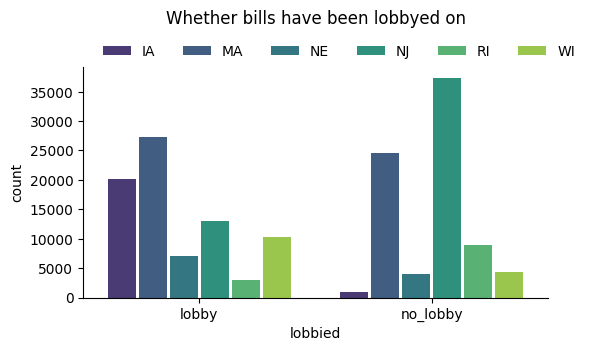

In [44]:
fig, ax = plt.subplots(figsize=(6, 3))
p = sns.countplot(features, x = "lobbied", hue = "state",stat = "count", 
                  palette= states_palette, gap = .1)
sns.move_legend(p, "upper center",  bbox_to_anchor=(0.55, 1.15), ncol=6,  frameon = False, title=None)
ax.set_title('Whether bills have been lobbyed on', y=1.15)
sns.despine()
plt.savefig("../figs/position_type.png")
del fig, ax, p

In [45]:
#chamber dist
print("Type of 'bill_chamber' abbr. for each state:")
print(features.value_counts(["state", "bill_chamber"], sort=False))

Type of 'bill_chamber' abbr. for each state:
state  bill_chamber
IA     HCR               128
       HF               8884
       HJR               151
       HR                445
       HSB              2237
       SCR                67
       SF               6422
       SJR               137
       SR                300
       SSB              2296
MA     H               33457
       S               18383
NE     LB               7466
       LR               3610
NJ     A               26617
       ACR              1110
       AJR               920
       AR               1252
       S               18420
       SCR               788
       SJR               569
       SR                658
RI     H                6773
       S                5070
WI     AB               7071
       AJR               836
       AR                187
       SB               5789
       SJR               634
       SR                 76
Name: count, dtype: int64


#### LEGISLATURE COMPOSITION



In [46]:
state_ide = pd.read_csv("../data/raw/shormccarty/shor mccarty 1993-2020 state aggregate data April 2023 release.tab", sep='\t')
state_ide = state_ide[state_ide["st"].isin(states_lobby)]                       #subset states
state_ide = state_ide[state_ide["year"].isin(features["year"].unique())]   #subset years
#subset cols 
state_ide = state_ide[[
    'st', 'year', 'hou_chamber', 'sen_chamber', 'hou_dem', 'hou_rep', 'hou_majority', 'hou_minority',
    'hou_dem_mean', 'hou_rep_mean', 'sen_dem', 'sen_rep', 'sen_majority', 'sen_minority', 'sen_dem_mean', 
    'sen_rep_mean', 'h_diffs', 's_diffs', 'h_distance', 's_distance', 'h_dem_sd', 's_dem_sd', 'h_rep_sd', 
    's_rep_sd', 'h_chamber_sd', 's_chamber_sd', 'hou_dem_error', 'hou_chamber_error', 'hou_rep_error', 
    'hou_majority_error', 'sen_dem_error', 'sen_chamber_error', 'sen_rep_error', 'sen_majority_error']]
state_ide = state_ide.rename(columns={"st": "state"})

In [ ]:
pd.set_option('display.max_rows', None)
state_ide.head(3)

#subset for test pivoting 
state_IA = state_ide[state_ide["state"] == "IA"]

,state,year,hou_chamber,sen_chamber,hou_dem,hou_rep,hou_majority,hou_minority,hou_dem_mean,hou_rep_mean,sen_dem,sen_rep,sen_majority,sen_minority,sen_dem_mean,sen_rep_mean,h_diffs,s_diffs,h_distance,s_distance,h_dem_sd,s_dem_sd,h_rep_sd,s_rep_sd,h_chamber_sd,s_chamber_sd,hou_dem_error,hou_chamber_error,hou_rep_error,hou_majority_error,sen_dem_error,sen_chamber_error,sen_rep_error,sen_majority_error
324,IA,2009,-0.772,-0.826,-0.963,0.668,-0.963,0.668,-0.959582,0.654799,-0.912,0.683,-0.912,0.683,-0.922825,0.700143,1.631,1.595,0.891682,0.859980,0.159818,0.142500,0.172143,0.209300,0.820908,0.804556,0.020,0.029,0.021,0.020,0.026,0.028,0.033,0.026
325,IA,2010,-0.759,-0.826,-0.958,0.670,-0.958,0.670,-0.953944,0.662416,-0.912,0.683,-0.912,0.683,-0.922825,0.700143,1.628,1.595,0.896707,0.859980,0.160984,0.142500,0.177473,0.209300,0.823608,0.804556,0.021,0.028,0.020,0.021,0.027,0.029,0.032,0.027
326,IA,2011,0.492,-0.655,-0.958,0.666,0.666,-0.958,-0.973949,0.655046,-0.912,0.693,-0.912,0.693,-0.921644,0.692863,1.624,1.605,0.890445,0.913864,0.174481,0.159130,0.174738,0.166140,0.820666,0.830524,0.025,0.020,0.019,0.019,0.032,0.045,0.026,0.032
327,IA,2012,0.492,-0.662,-0.958,0.666,0.666,-0.958,-0.973949,0.655046,-0.912,0.693,-0.912,0.693,-0.929679,0.692863,1.624,1.605,0.890445,0.915324,0.174481,0.151274,0.174738,0.166140,0.820666,0.833756,0.025,0.021,0.019,0.019,0.032,0.046,0.026,0.032
328,IA,2013,0.465,-0.706,-0.944,0.702,0.702,-0.944,-0.939536,0.696422,-0.955,0.741,-0.955,0.741,-0.962249,0.767820,1.646,1.696,0.918761,0.963944,0.190660,0.139399,0.154369,0.157198,0.838345,0.885352,0.025,0.027,0.019,0.019,0.032,0.048,0.026,0.032
329,IA,2014,0.465,-0.706,-0.945,0.702,0.702,-0.945,-0.943207,0.696466,-0.955,0.750,-0.955,0.750,-0.962249,0.773921,1.647,1.705,0.920118,0.966778,0.189023,0.139399,0.154404,0.156006,0.840001,0.888289,0.025,0.026,0.020,0.020,0.033,0.046,0.025,0.033
330,IA,2015,0.540,-0.687,-0.962,0.708,0.708,-0.962,-0.977684,0.703724,-0.938,0.784,-0.938,0.784,-0.944446,0.808469,1.670,1.722,0.918146,0.974309,0.168993,0.146475,0.139091,0.144281,0.850288,0.896280,0.026,0.021,0.019,0.019,0.031,0.052,0.025,0.031
331,IA,2016,0.540,-0.687,-0.962,0.708,0.708,-0.962,-0.977684,0.710090,-0.938,0.784,-0.938,0.784,-0.944446,0.808469,1.670,1.722,0.921546,0.974309,0.168993,0.146475,0.139681,0.144281,0.853459,0.896280,0.026,0.022,0.019,0.019,0.031,0.052,0.025,0.031
332,IA,2017,0.573,0.699,-0.996,0.712,0.712,-0.996,-0.995111,0.727897,-0.944,0.790,0.790,-0.944,-0.949026,0.812052,1.708,1.734,0.943176,0.957475,0.166826,0.158878,0.222059,0.150085,0.874946,0.885422,0.027,0.022,0.020,0.020,0.034,0.031,0.026,0.026
333,IA,2018,0.581,0.698,-0.996,0.712,0.712,-0.996,-0.997834,0.732819,-0.944,0.792,0.792,-0.944,-0.949026,0.806898,1.708,1.736,0.945429,0.952357,0.164865,0.158878,0.220460,0.156147,0.878239,0.880879,0.027,0.023,0.021,0.021,0.035,0.034,0.024,0.024


,state,year,hou_chamber,sen_chamber,hou_dem,hou_rep,hou_majority,hou_minority,hou_dem_mean,hou_rep_mean,sen_dem,sen_rep,sen_majority,sen_minority,sen_dem_mean,sen_rep_mean,h_diffs,s_diffs,h_distance,s_distance,h_dem_sd,s_dem_sd,h_rep_sd,s_rep_sd,h_chamber_sd,s_chamber_sd,hou_dem_error,hou_chamber_error,hou_rep_error,hou_majority_error,sen_dem_error,sen_chamber_error,sen_rep_error,sen_majority_error
324,IA,2009,-0.772,-0.826,-0.963,0.668,-0.963,0.668,-0.959582,0.654799,-0.912,0.683,-0.912,0.683,-0.922825,0.700143,1.631,1.595,0.891682,0.859980,0.159818,0.14250,0.172143,0.20930,0.820908,0.804556,0.020,0.029,0.021,0.020,0.026,0.028,0.033,0.026
325,IA,2010,-0.759,-0.826,-0.958,0.670,-0.958,0.670,-0.953944,0.662416,-0.912,0.683,-0.912,0.683,-0.922825,0.700143,1.628,1.595,0.896707,0.859980,0.160984,0.14250,0.177473,0.20930,0.823608,0.804556,0.021,0.028,0.020,0.021,0.027,0.029,0.032,0.027
326,IA,2011,0.492,-0.655,-0.958,0.666,0.666,-0.958,-0.973949,0.655046,-0.912,0.693,-0.912,0.693,-0.921644,0.692863,1.624,1.605,0.890445,0.913864,0.174481,0.15913,0.174738,0.16614,0.820666,0.830524,0.025,0.020,0.019,0.019,0.032,0.045,0.026,0.032


In [ ]:
pd.wide_to_long(state_ide, 
                stubnames = ["sen", "hou", "h", "s"], 
                i = ["state", "year"], 
                #j = "chamber", 
                sep="_", 
                #suffix="rep"
                )

h_chamber_sd  h_dem_sd  h_diffs  h_distance  h_rep_sd  \
state year chamber                                                          
IA    2009 rep          0.820908  0.159818    1.631    0.891682  0.172143   
      2010 rep          0.823608  0.160984    1.628    0.896707  0.177473   
      2011 rep          0.820666  0.174481    1.624    0.890445  0.174738   
      2012 rep          0.820666  0.174481    1.624    0.890445  0.174738   
      2013 rep          0.838345  0.190660    1.646    0.918761  0.154369   
      2014 rep          0.840001  0.189023    1.647    0.920118  0.154404   
      2015 rep          0.850288  0.168993    1.670    0.918146  0.139091   
      2016 rep          0.853459  0.168993    1.670    0.921546  0.139681   
      2017 rep          0.874946  0.166826    1.708    0.943176  0.222059   
      2018 rep          0.878239  0.164865    1.708    0.945429  0.220460   
      2019 rep          0.878753  0.202619    1.703    0.958231  0.224127   
      2020 rep          0.882720  0.179322    1.719    0.959847  0.224127   
MA    2009 rep          0.398359  0.102219    1.259    0.326052  0.091250   
      2010 rep          0.398023  0.103396    1.260    0.326255  0.091250   
      2011 rep          0.553826  0.106731    1.273    0.517770  0.210441   
      2012 rep          0.560692  0.108208    1.273    0.528738  0.210441   
      2013 rep          0.529574  0.120513    1.288    0.494181  0.167255   
      2014 rep          0.529695  0.128075    1.292    0.496322  0.169669   
      2015 rep          0.561360  0.140960    1.281    0.553549  0.166451   
      2016 rep          0.555664  0.142171    1.279    0.545317  0.166962   
      2017 rep          0.575660  0.179796    1.281    0.578325  0.164587   
      2018 rep          0.576190  0.180429    1.290    0.577604  0.162159   
      2019 rep          0.565506  0.196286    1.292    0.575950  0.120499   
      2020 rep          0.569358  0.196216    1.289    0.580945  0.124105   
NE    2009 rep               NaN       NaN      NaN         NaN       NaN   
      2010 rep               NaN       NaN      NaN         NaN       NaN   
      2011 rep               NaN       NaN      NaN         NaN       NaN   
      2012 rep               NaN       NaN      NaN         NaN       NaN   
      2013 rep               NaN       NaN      NaN         NaN       NaN   
      2014 rep               NaN       NaN      NaN         NaN       NaN   
      2015 rep               NaN       NaN      NaN         NaN       NaN   
      2016 rep               NaN       NaN      NaN         NaN       NaN   
      2017 rep               NaN       NaN      NaN         NaN       NaN   
      2018 rep               NaN       NaN      NaN         NaN       NaN   
      2019 rep               NaN       NaN      NaN         NaN       NaN   
      2020 rep               NaN       NaN      NaN         NaN       NaN   
NJ    2009 rep          0.640417  0.131345    1.182    0.697160  0.166965   
      2010 rep          0.618001  0.120526    1.182    0.667582  0.130445   
      2011 rep          0.616205  0.118591    1.178    0.663508  0.129511   
      2012 rep          0.623504  0.117807    1.197    0.672151  0.146236   
      2013 rep          0.620676  0.145754    1.194    0.672610  0.154330   
      2014 rep          0.623948  0.136252    1.197    0.676193  0.156965   
      2015 rep          0.630480  0.135351    1.200    0.684816  0.164279   
      2016 rep          0.610579  0.182186    1.189    0.663905  0.159951   
      2017 rep          0.612069  0.185266    1.183    0.668752  0.160333   
      2018 rep          0.597639  0.205679    1.191    0.647980  0.147898   
      2019 rep          0.607350  0.206791    1.191    0.666767  0.150966   
      2020 rep          0.609047  0.190948    1.202    0.667926  0.145295   
RI    2009 rep          0.131659  0.087475    0.363    0.137844  0.108295   
      2010 rep          0.132390  0.088057    0.363    0.138861  0.108295   
      2011 rep  

TypeError: wide_to_long() missing 1 required positional argument: 'j'

In [26]:
###save selected features to parquet 
with open("../data/preprocessed/features.pkl", 'wb') as file:
    pkl.dump(features, file)

### FEATURE TRANSFORMATIONS

- PASS: outcome - remove from remaining data !
- STATE: one hot encoding
- TOPICS: multi-var encoding
- METATOPICS: multi-var encoding
- YEAR: ordinal encoding
- BLOCKS: multi-var encoding
- COUNTS: multi-var enc structure; but keeping values and log transforming

In [2]:
#get saved features 
with open('../data/preprocessed/features.pkl', 'rb') as file:
    features = pkl.load(file)


number of samples: 160753
distribution of bills with position data and no position data:
lobbied
lobby       0.501552
no_lobby    0.498448
Name: proportion, dtype: float64


,state_unified_bill_id,pass,state,ncsl_topics,ncsl_metatopics,bill_year,neut_blocks,opp_blocks,sup_blocks,neut_counts,opp_counts,sup_counts,lobbied
0,IA_H_0000000001_2013,failed,IA,[M],[M],2013,"[107, 116, 196, 262, 5, 51, 70, 86]","[107, 115, 191, 62, 90]","[32, 70]","[4, 2, 12, 4, 9, 11, 1, 6]","[4, 2, 2, 4, 1]","[1, 4]",lobby
1,IA_H_0000000002_2013,failed,IA,[M],[M],2013,"[107, 119, 12, 161, 19, 196, 203, 23, 26, 262,...","[107, 115, 191, 62]","[169, 19, 262, 70]","[4, 7, 1, 6, 5, 3, 2, 2, 4, 3, 6, 11, 11, 2, 5...","[5, 1, 2, 6]","[3, 4, 4, 3]",lobby
2,IA_H_0000000011_2013,failed,IA,[M],[M],2013,"[12, 19, 220, 231, 250, 262, 45, 51, 58, 80]","[115, 181, 19, 195, 209, 212, 45]","[161, 32, 70]","[1, 14, 3, 1, 2, 3, 6, 10, 1, 2]","[1, 3, 12, 4, 3, 2, 3]","[1, 8, 1]",lobby
3,IA_H_0000000101_2013,failed,IA,[M],[M],2013,"[107, 116, 140, 195, 250, 27, 79, 90]",N,"[140, 195, 79, 90]","[4, 1, 5, 19, 1, 1, 3, 4]",0,"[11, 1, 3, 4]",lobby
4,IA_H_0000002351_2013,failed,IA,[M],[M],2014,"[146, 19, 5]",N,"[12, 146, 169, 23, 79, 80]","[3, 2, 3]",0,"[1, 1, 1, 1, 3, 1]",lobby


In [ ]:
#STATES
enc_states = OneHotEncoder()
X_states = enc_states.fit_transform(features[["state"]].to_numpy())
names_states = enc_states.get_feature_names_out(["state"]) 
print(f"X_states have same length as n_samples: {X_states.shape[0] == n_samples}")

#LOBBIED
enc_lobbied = OneHotEncoder()
X_lobbied = enc_lobbied.fit_transform(features[["lobbied"]].to_numpy())
names_lobbied = enc_lobbied.get_feature_names_out(["lobbied"]) 
print(f"X_lobbied have same length as n_samples: {X_lobbied.shape[0] == n_samples}")

#TOPICS & METATOPICS
enc_topics = CountVectorizer(analyzer=lambda lst: lst)
X_topics = enc_topics.fit_transform(features["ncsl_topics"]).toarray()
names_topics = enc_topics.get_feature_names_out() 
print(f"X_topics have same length as n_samples: {X_topics.shape[0] == n_samples}")

enc_metatopics = CountVectorizer(analyzer=lambda lst: lst)
X_metatopics = enc_metatopics.fit_transform(features["ncsl_metatopics"]).toarray()
names_metatopics = enc_metatopics.get_feature_names_out() 
print(f"X_metatopics have same length as n_samples: {X_metatopics.shape[0] == n_samples}")

#BLOCKS: NEUTRAL, OPPOSE, SUPPORT
enc_blocks = CountVectorizer(analyzer=lambda lst: lst)
#concatenate neut_blocks, opp_blocks and sup_blocks and fit encoder to them
enc_blocks.fit(np.concatenate((features["neut_blocks"].to_numpy(), features["opp_blocks"].to_numpy(), features["sup_blocks"].to_numpy())))
blocks_names = enc_blocks.get_feature_names_out()
#transform each of the cols 
X_neut_blocks = enc_blocks.transform(features["neut_blocks"]).toarray()
X_sup_blocks = enc_blocks.transform(features["sup_blocks"]).toarray()
X_opp_blocks = enc_blocks.transform(features["opp_blocks"]).toarray()

#BLOCKS: COUNTS
#assign count values to given block indeces in each of the position cols
x_opp_counts = features["opp_counts"] #count features: oppose
x_sup_counts = features["sup_counts"] #count features: support
x_neut_counts = features["neut_counts"] #count features: neutral

X_opp_blocks = block_counts(X_opp_blocks, x_opp_counts)
X_sup_blocks = block_counts(X_sup_blocks, x_sup_counts)
X_neut_blocks = block_counts(X_neut_blocks, x_neut_counts)
print(f"X_neut_blocks have same length as n_samples: {X_neut_blocks.shape[0] == n_samples}\nX_opp_blocks have same length as n_samples: {X_opp_blocks.shape[0] == n_samples}\nX_sup_blocks have same length as n_samples: {X_sup_blocks.shape[0] == n_samples}\n")

#YEARS
years = [[2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]]
enc_year = OrdinalEncoder(categories= years, dtype="int32")
X_year = enc_year.fit_transform(features[["bill_year"]].to_numpy())
names_year = enc_year.get_feature_names_out(["bill_year"])
enc_year.categories_
print(f"X_year have same length as n_samples: {X_year.shape[0] == n_samples}")

X_states have same length as n_samples: True
